In [12]:
import os
import pandas as pd
import sqlite3
import requests
from dotenv import load_dotenv
from pathlib import Path

ROOT = Path.cwd().parent
load_dotenv(ROOT / '.env')
api_key = os.getenv('EXCHANGE_RATE_API_KEY')

In [13]:
base_currency = "USD"
url_currency_rates = f"https://v6.exchangerate-api.com/v6/{api_key}/latest/{base_currency}"
req_currency = requests.get(url_currency_rates)

data = req_currency.json()

# Extract conversion rates and create DataFrame
conversion_rates = pd.DataFrame(data['conversion_rates'].items(), columns=['Currency_Code', 'Rate'])

# Sort DataFrame by Rate in descending order
highest_rates = conversion_rates.sort_values(by="Rate", ascending=False).reset_index(drop=True)
highest_rates["date"] = data["time_last_update_utc"].split(" 00:")[0]
highest_rates.head()

,Currency_Code,Rate,date
0,LBP,89500.0000,"Sun, 16 Jun 2024"
1,IRR,42108.3265,"Sun, 16 Jun 2024"
2,VND,25416.7614,"Sun, 16 Jun 2024"
3,SLL,22967.6967,"Sun, 16 Jun 2024"
4,LAK,21778.3070,"Sun, 16 Jun 2024"


- **Improvement**: Add country names from this site (quick scraping) https://www.foreignexchangelive.com/currency-codes-symbols/

In [26]:
url_currency_codes = f'https://v6.exchangerate-api.com/v6/{api_key}/codes'
req_codes = requests.get(url_currency_codes)
data_code = req_codes.json()
codes = pd.DataFrame(data_code["supported_codes"], columns=["Currency_Code", "Currency_Name"])

In [29]:
import sqlite3
# Create a sqlite3 database
conn = sqlite3.connect(Path(ROOT / 'data' / 'currency_rates.db'))
c = conn.cursor()

# Query the database, show tables
c.execute('''
SELECT name
FROM sqlite_master
WHERE type='table'
''')

print(c.fetchall())

[('currency_names',), ('currency_rates',), ('sqlite_sequence',)]


- Look at the currency rates tables

In [35]:
currency_rate_df = pd.read_sql_query("SELECT * FROM currency_rates", conn)
currency_rate_df.head()

,id,currency_code,rate,date
0,1,USD,1.0000,"Mon, 03 Jun 2024"
1,2,AED,3.6725,"Mon, 03 Jun 2024"
2,3,AFN,71.2981,"Mon, 03 Jun 2024"
3,4,ALL,92.9346,"Mon, 03 Jun 2024"
4,5,AMD,387.6778,"Mon, 03 Jun 2024"


- Look at the currency names

In [38]:
currency_names_df = pd.read_sql_query("SELECT * FROM currency_names", conn)
currency_names_df.head()

,currency_code,currency_name
0,AED,UAE Dirham
1,AFN,Afghan Afghani
2,ALL,Albanian Lek
3,AMD,Armenian Dram
4,ANG,Netherlands Antillian Guilder


In [91]:
query = '''
SELECT currency_rates.Currency_Code, currency_names.Currency_Name, currency_rates.Rate, currency_rates.date
FROM currency_rates
JOIN currency_names
ON currency_rates.Currency_Code = currency_names.Currency_Code
'''

currency_df = pd.read_sql_query(query, conn)
currency_df.head()

,currency_code,currency_name,rate,date
0,USD,United States Dollar,1.0000,"Mon, 03 Jun 2024"
1,AED,UAE Dirham,3.6725,"Mon, 03 Jun 2024"
2,AFN,Afghan Afghani,71.2981,"Mon, 03 Jun 2024"
3,ALL,Albanian Lek,92.9346,"Mon, 03 Jun 2024"
4,AMD,Armenian Dram,387.6778,"Mon, 03 Jun 2024"


- Some visualizations

<Axes: title={'center': 'Euro value in USD'}, xlabel='date_standard_format', ylabel='USD'>

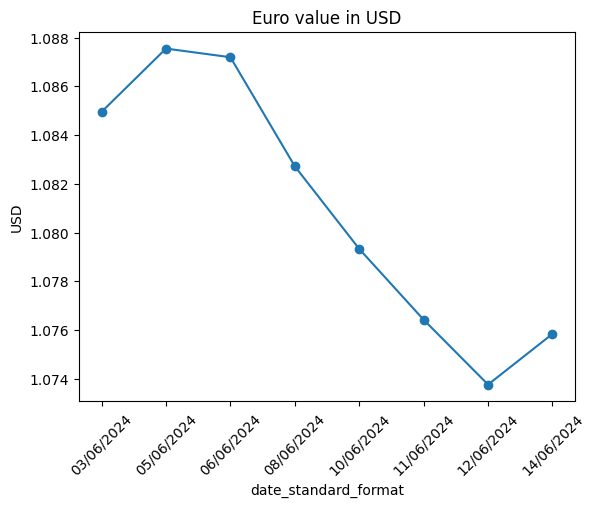

In [99]:
currency_df["in_dollars"] = 1 / currency_df["rate"]
# Convert date to DD/MM/YYYY format
currency_df["date_standard_format"] = pd.to_datetime(currency_df["date"]).dt.strftime('%d/%m/%Y')

# Rotate the xticks for better readability
currency_df[currency_df["currency_name"].str.contains("Euro")].plot(x="date_standard_format", y="in_dollars", title="Euro value in USD", ylabel="USD", xlabel="date_standard_format", rot=45, marker = "o", legend=False)

- Handling missing values (WIP)

In [112]:
currency_df_euro = currency_df[currency_df["currency_name"].str.contains("Euro")]
currency_df_euro["date_standard_format"] = pd.to_datetime(currency_df_euro["date_standard_format"], format="%d/%m/%Y")

first_date = currency_df_euro["date_standard_format"].min().strftime('%d/%m/%Y')
last_date = currency_df_euro["date_standard_format"].max().strftime('%d/%m/%Y')
print("First date:", first_date)
print("Last date:", last_date)

# Create a complete DataFrame with date range
complete_dates = pd.date_range(start=currency_df_euro["date_standard_format"].min(),
                               end=currency_df_euro["date_standard_format"].max(), freq="D")
complete_df_euro = pd.DataFrame({"date_standard_format": complete_dates.strftime('%d/%m/%Y')})
complete_df_euro["date_standard_format"] = complete_df_euro["date_standard_format"].astype("datetime64[ns]")

complete_df_euro.merge(currency_df_euro, on="date_standard_format", how="left")

First date: 03/06/2024
Last date: 14/06/2024


C:\Users\mabid\AppData\Local\Temp\ipykernel_31604\2138492740.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  currency_df_euro["date_standard_format"] = pd.to_datetime(currency_df_euro["date_standard_format"], format="%d/%m/%Y")


,date_standard_format,currency_code,currency_name,rate,date,in_dollars
0,2024-03-06,NaN,NaN,NaN,NaN,NaN
1,2024-04-06,NaN,NaN,NaN,NaN,NaN
2,2024-05-06,NaN,NaN,NaN,NaN,NaN
3,2024-06-06,EUR,Euro,0.9198,"Thu, 06 Jun 2024",1.087193
4,2024-07-06,NaN,NaN,NaN,NaN,NaN
5,2024-08-06,NaN,NaN,NaN,NaN,NaN
6,2024-09-06,NaN,NaN,NaN,NaN,NaN
7,2024-10-06,NaN,NaN,NaN,NaN,NaN
8,2024-11-06,NaN,NaN,NaN,NaN,NaN
9,2024-12-06,NaN,NaN,NaN,NaN,NaN


In [101]:
currency_df_euro

,currency_code,currency_name,rate,date,in_dollars,date_standard_format
43,EUR,Euro,0.9217,"Mon, 03 Jun 2024",1.084952,2024-06-03
205,EUR,Euro,0.9195,"Wed, 05 Jun 2024",1.087548,2024-06-05
367,EUR,Euro,0.9198,"Thu, 06 Jun 2024",1.087193,2024-06-06
529,EUR,Euro,0.9236,"Sat, 08 Jun 2024",1.082720,2024-06-08
691,EUR,Euro,0.9265,"Mon, 10 Jun 2024",1.079331,2024-06-10
853,EUR,Euro,0.9290,"Tue, 11 Jun 2024",1.076426,2024-06-11
1015,EUR,Euro,0.9313,"Wed, 12 Jun 2024",1.073768,2024-06-12
1177,EUR,Euro,0.9295,"Fri, 14 Jun 2024",1.075847,2024-06-14
